<a href="https://colab.research.google.com/github/revanthbethala/shoreline_extraction/blob/main/data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio albumentations

In [ ]:
# -----------------------------------------------------
# data aug-corrected
#-----------------------------------------------------
!pip install rasterio albumentations
import os
import rasterio
import albumentations as A
import numpy as np

# ============================================
# CONFIGURATION
# ============================================
base_dir = '/content/drive/MyDrive/shoreline_data'       # Folder that already contains year subfolders
output_base = '/content/drive/MyDrive/data_aug'          # Folder where augmented data will be saved

# Albumentations augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.3),
])

# ============================================
# AUGMENTATION FUNCTION
# ============================================
def augment_and_save(image_path, out_path):
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        meta = src.meta.copy()

        # Normalize to [0,1] for Albumentations safety
        image = image.astype(np.float32)
        if np.max(image) > 0:
            image = image / np.max(image)

        # Albumentations expects HWC format
        image_hw = np.transpose(image, (1, 2, 0))

        augmented = transform(image=image_hw)
        aug_image = augmented["image"]

        # Convert back to CHW format
        aug_image_chw = np.transpose(aug_image, (2, 0, 1))

        # Rescale back to original dtype range
        if src.meta["dtype"] == "uint8":
            aug_image_chw = np.clip(aug_image_chw * 255, 0, 255).astype(np.uint8)
        else:
            aug_image_chw = np.clip(aug_image_chw, 0, 1).astype(np.float32)

        meta.update({
            "height": aug_image_chw.shape[1],
            "width": aug_image_chw.shape[2],
            "count": aug_image_chw.shape[0],
        })

        # Save augmented image
        with rasterio.open(out_path, "w", **meta) as dst:
            dst.write(aug_image_chw)

# ============================================
# PROCESSING FUNCTION
# ============================================
def process_all_images(root_dir, output_root):
    os.makedirs(output_root, exist_ok=True)

    for year_folder in os.listdir(root_dir):
        year_path = os.path.join(root_dir, year_folder)
        if not os.path.isdir(year_path):
            continue

        img_files = [f for f in os.listdir(year_path) if f.endswith(('.tif', '.tiff'))]
        if not img_files:
            continue

        print(f"\n📅 {year_folder}: {len(img_files)} images found.")

        # Create year-specific output folder
        out_year_path = os.path.join(output_root, year_folder)
        os.makedirs(out_year_path, exist_ok=True)

        # Determine augmentation count
        target_count = 30 if len(img_files) >= 5 else len(img_files) * 10
        augmentations_per_image = max(1, target_count // len(img_files))

        print(f"🔁 Generating {augmentations_per_image} augmentations per image (target: {target_count})")

        for img_file in img_files:
            in_img_path = os.path.join(year_path, img_file)
            base_name = os.path.splitext(img_file)[0]

            for i in range(augmentations_per_image):
                out_img_path = os.path.join(out_year_path, f"{base_name}_aug{i+1}.tif")
                try:
                    augment_and_save(in_img_path, out_img_path)
                    print(f"✅ Saved: {out_img_path}")
                except Exception as e:
                    print(f"❌ Failed on {img_file}: {e}")

# ============================================
# MAIN
# ============================================
if __name__ == "__main__":
    process_all_images(base_dir, output_base)
    print("\n✅ Augmentation complete! All augmented data saved in 'data_aug' folder.")



📅 1990: 1 images found.
🔁 Generating 10 augmentations per image (target: 10)
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug1.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug2.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug3.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug4.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug5.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug6.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug7.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug8.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug9.tif
✅ Saved: /content/drive/MyDrive/data_aug/1990/1990_landsat5_637474744302_aug10.tif

📅 1991: 8 images found.
🔁 Generating 3 augmentations per image (target: 30)
✅ Saved: /content/drive/


KeyboardInterrupt



🖼 Found 10 GeoTIFF files in /content/drive/MyDrive/data_aug/1990

📜 File Names:
1 1990_landsat5_637474744302_aug1.tif
2 1990_landsat5_637474744302_aug10.tif
3 1990_landsat5_637474744302_aug2.tif
4 1990_landsat5_637474744302_aug3.tif
5 1990_landsat5_637474744302_aug4.tif
6 1990_landsat5_637474744302_aug5.tif
7 1990_landsat5_637474744302_aug6.tif
8 1990_landsat5_637474744302_aug7.tif
9 1990_landsat5_637474744302_aug8.tif
10 1990_landsat5_637474744302_aug9.tif


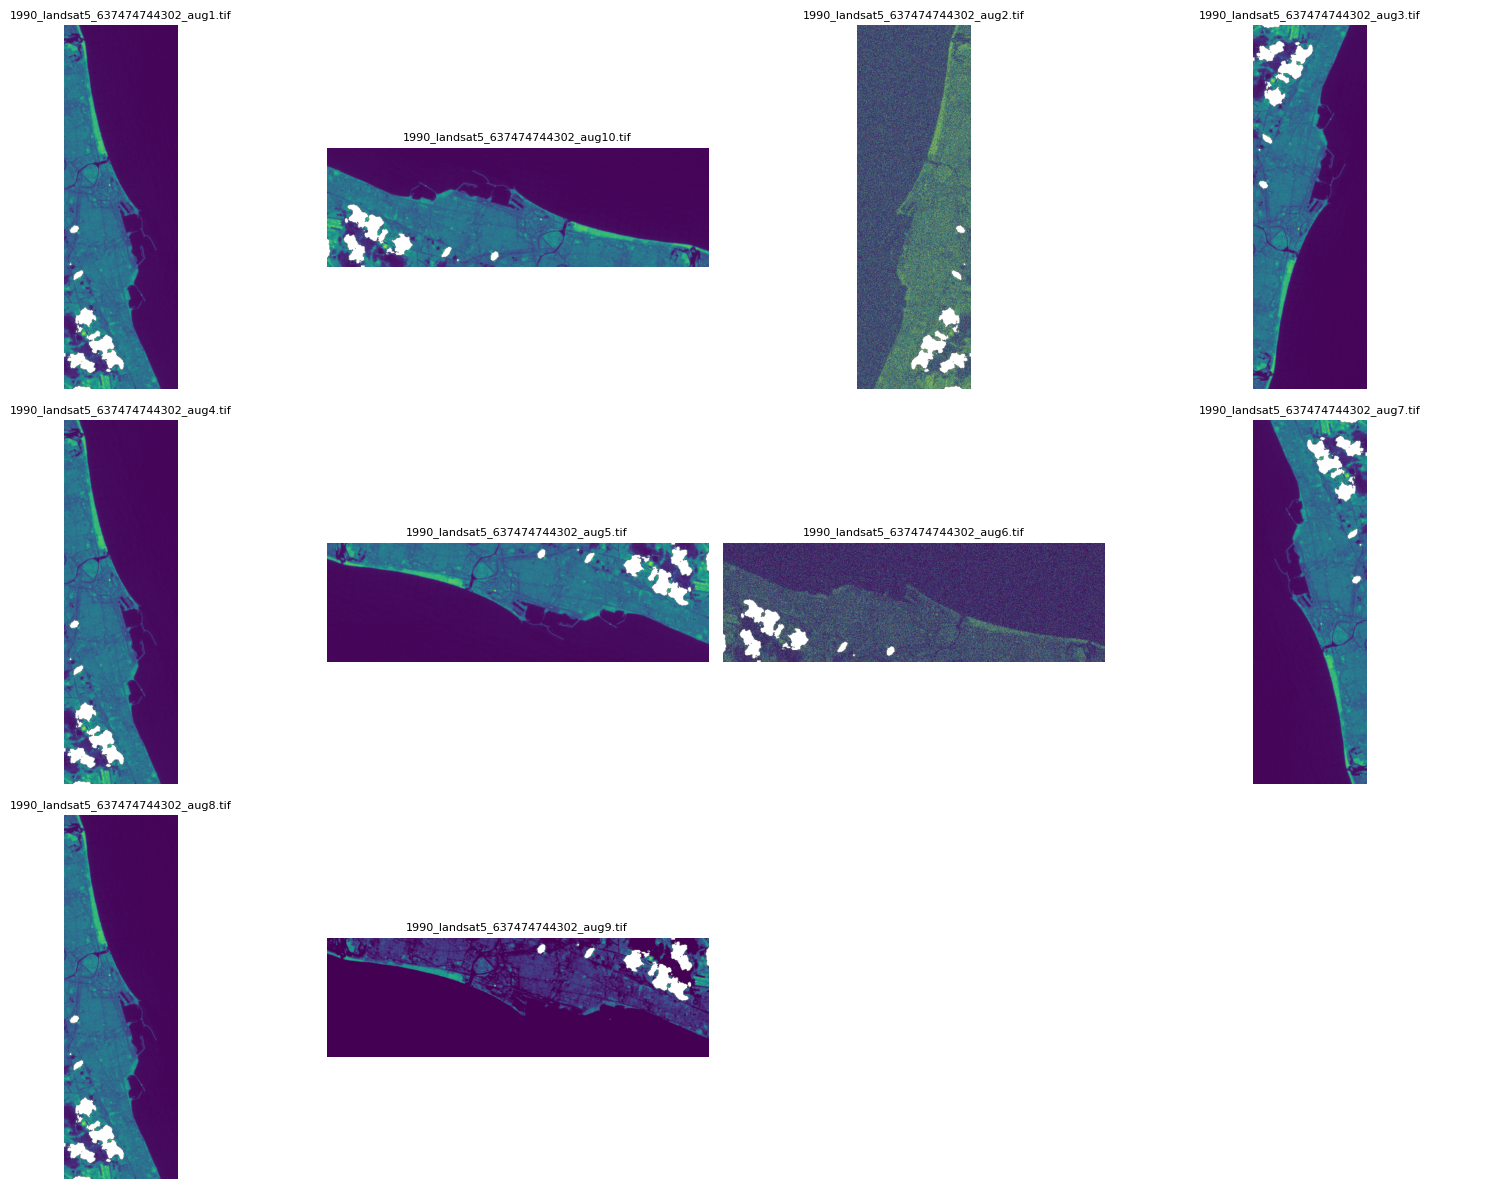

In [ ]:
# ---------------------------------------------------
#  view tiff images
# --------------------------------------------------
import os
import math
import rasterio
import matplotlib.pyplot as plt
# ============================================
# CONFIGURATION
# ============================================
folder_path = f"/content/drive/MyDrive/data_aug/1990"  # Change year as needed

# Get all .tif/.tiff files
tif_files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(('.tif', '.tiff'))])

print(f"🖼 Found {len(tif_files)} GeoTIFF files in {folder_path}")

if not tif_files:
    raise ValueError("No .tif files found in the specified folder!")

# ============================================
# PRINT FILENAMES (COPY-FRIENDLY)
# ============================================
print("\n📜 File Names:")
for count,name in enumerate(tif_files):
    print(f"{count+1} {name}")
# ============================================
# GRID SETTINGS
# ============================================
cols = 4  # number of images per row
rows = math.ceil(len(tif_files) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()

# ============================================
# DISPLAY IMAGES
# ============================================
for i, tif_file in enumerate(tif_files):
    img_path = os.path.join(folder_path, tif_file)
    try:
        with rasterio.open(img_path) as src:
            band = src.read(5)  # show first band

        axes[i].imshow(band, cmap='viridis')
        axes[i].set_title(tif_file, fontsize=8)
        axes[i].axis('off')

    except Exception as e:
        print(f"❌ Error reading {tif_file}: {e}")
        axes[i].axis('off')
        axes[i].set_title("Error", fontsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os

# ============================================
# CONFIGURATION
# ============================================
data_aug_dir = '/content/drive/MyDrive/shoreline_data_augmented'

# ============================================
# COUNT FUNCTION
# ============================================
def count_images_by_year(root_dir):
    total_images = 0
    year_counts = {}

    for year_folder in os.listdir(root_dir):
        year_path = os.path.join(root_dir, year_folder)
        if not os.path.isdir(year_path):
            continue

        # Count only .tif / .tiff files
        img_files = [f for f in os.listdir(year_path) if f.lower().endswith(('.tif', '.tiff'))]
        count = len(img_files)
        year_counts[year_folder] = count
        total_images += count

    print("\n📊 Image Count Summary:")
    print("-" * 40)
    print(sorted(year_counts.keys()))
    for year, count in sorted(year_counts.items()):
        print(f"📅 {year}: {count} images")
    print("-" * 40)
    print(f"🧮 Total images across all years: {total_images}")

# ============================================
# MAIN
# ============================================
if __name__ == "__main__":
    count_images_by_year(data_aug_dir)



📊 Image Count Summary:
----------------------------------------
['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
📅 1990: 11 images
📅 1991: 32 images
📅 1992: 36 images
📅 1993: 35 images
📅 1994: 40 images
📅 1995: 32 images
📅 1996: 38 images
📅 1997: 35 images
📅 1998: 11 images
📅 1999: 15 images
📅 2000: 40 images
📅 2001: 40 images
📅 2002: 35 images
📅 2003: 36 images
📅 2004: 39 images
📅 2005: 39 images
📅 2006: 36 images
📅 2007: 36 images
📅 2008: 45 images
📅 2009: 36 images
📅 2010: 35 images
📅 2011: 32 images
📅 2012: 35 images
📅 2013: 35 images
📅 2014: 36 images
📅 2015: 32 images
📅 2016: 42 images
📅 2017: 45 images
📅 2018: 33 images
📅 2019: 53 images
📅 2020: 42 images
📅 2021: 43 images
📅 2022: 35 images
📅 2023: 39 images
📅 2024: 39 images
------------------------